/Users/arthurostrauss/anaconda3/envs/rl_qoc_v1/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


Circuit context


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/template_configurations/qiskit/gate_level/q_env_config.py:105: UserWarning: No backend was provided, State vector simulation will be used
  warnings.warn("No backend was provided, State vector simulation will be used")


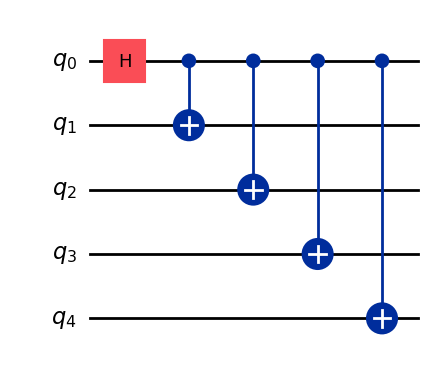

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from template_configurations.qiskit.gate_level import (
    q_env_config as gate_q_env_config,
    circuit_context,
)
from quantumenvironment import QuantumEnvironment
from context_aware_quantum_environment import ContextAwareQuantumEnvironment
from gymnasium.wrappers import RescaleAction, ClipAction

circuit_context.draw("mpl")

In [2]:
from qiskit.visualization import plot_gate_map, plot_circuit_layout

if (
        gate_q_env_config.backend_config.backend is not None
        and circuit_context.layout is not None
):
    plot_circuit_layout(
        circuit_context, gate_q_env_config.backend_config.backend, view="physical"
    )

In [3]:
use_context = False
if use_context:
    q_env = ContextAwareQuantumEnvironment(
        gate_q_env_config, circuit_context, training_steps_per_gate=250
    )
else:
    q_env = QuantumEnvironment(gate_q_env_config)
rescaled_env = RescaleAction(ClipAction(q_env), -1.0, 1.0)

/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/helper_functions.py:1758: UserWarning: No Backend was provided, using default values for dt, coupling_map, basis_gates and instruction_durations
  warnings.warn(
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/quantumenvironment.py:957: ComplexWarning: Casting complex values to real discards the imaginary part
  array_obs[pauli_to_index[pauli.paulis[0]]] = pauli.coeffs[0]


Sending Estimator job...
SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 0.5+0.j, -0.5+0.j, -0.5+0.j,  0.5+0.j])
Finished Estimator job
Starting simulation benchmark...
Avg gate fidelity: 0.2428408141739671
Finished simulation benchmark
C Factor adjusted to  1.0359641690168837


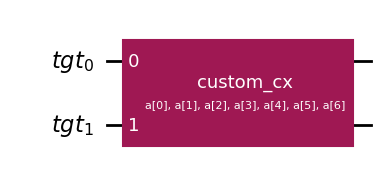

In [4]:
q_env.circuit_truncations[0].draw("mpl", style="iqp")

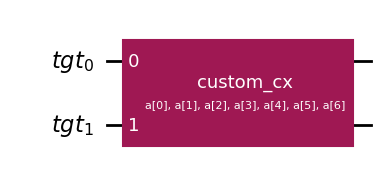

In [5]:
from qiskit import transpile

circuit = transpile(q_env.circuit_truncations[0], q_env.backend, optimization_level=1)
circuit.draw("mpl")

In [6]:
if use_context:
    q_env.circuit_context.draw("mpl")

In [7]:
from qiskit.visualization import plot_gate_map

if q_env.backend is not None and q_env.backend_info.coupling_map.size() != 0:
    plot_gate_map(q_env.backend)

In [8]:
from helper_functions import load_from_yaml_file

agent_config = load_from_yaml_file(
    "/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/template_configurations/agent_config.yaml"
)
# import yaml
# with open(
#         ,
#         "r",
# ) as f:
#     agent_config = yaml.safe_load(f)

In [9]:
from ppo import CustomPPO

ppo_agent = CustomPPO(agent_config, rescaled_env)

In [10]:
q_env.avg_fidelity_history

[]

In [11]:
ppo_agent.train(total_updates=500, print_debug=False, num_prints=1, clear_history=False)

 53%|█████▎    | 266/500 [01:48<01:35,  2.44it/s]


KeyboardInterrupt: 

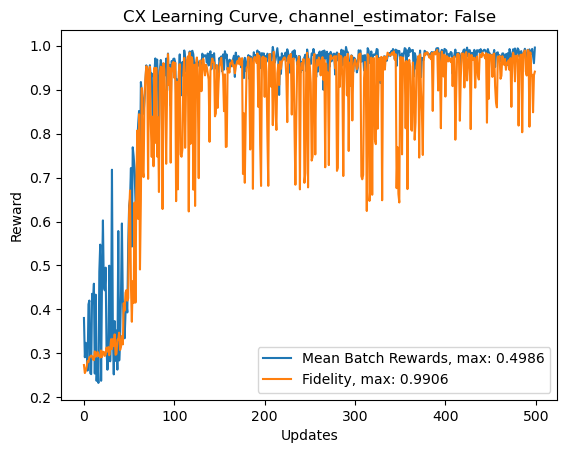

In [12]:
import numpy as np
import matplotlib.pyplot as plt

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(2 * mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target['gate'].name.upper()} Learning Curve, channel_estimator: {q_env.channel_estimator}"
)
plt.legend()
plt.show()

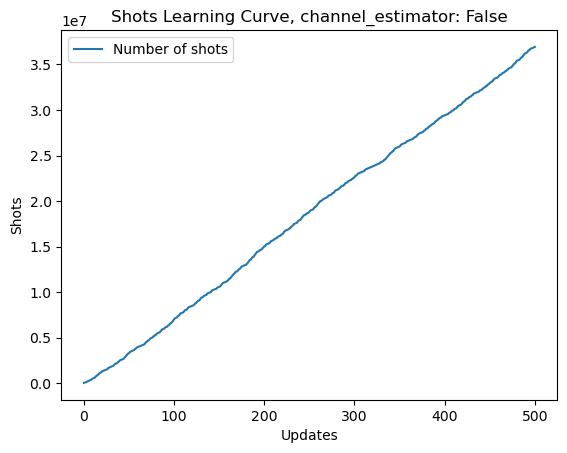

In [13]:
plt.plot(np.cumsum(q_env.total_shots), label="Number of shots")
plt.xlabel("Updates")
plt.ylabel("Shots")
plt.title(f"Shots Learning Curve, channel_estimator: {q_env.channel_estimator}")
plt.legend()

In [14]:
convergence_iteration = 60
print(
    "Number of shots required for convergence:",
    np.cumsum(q_env.total_shots[:convergence_iteration]),
)

Number of shots required for convergence: [  46080   81920  120320  168960  207360  263680  304640  353280  391680
  491520  532480  576000  624640  755200  803840  919040  960000 1113600
 1157120 1198080 1313280 1356800 1390080 1441280 1479680 1518080 1553920
 1684480 1733120 1774080 1822720 1866240 1907200 1943040 2096640 2140160
 2193920 2232320 2355200 2401280 2531840 2567680 2608640 2654720 2698240
 2813440 2920960 3043840 3159040 3274240 3322880 3445760 3486720 3548160
 3591680 3640320 3681280 3811840 3855360 3955200]


In [15]:
q_env.optimal_action / np.pi

array([ 0.03005903, -0.28540799, -0.20261182,  0.46387239,  0.51433585,
       -0.47693557,  0.47733007])

In [ ]:
from torchsummary import summary

summary(ppo_agent.agent, q_env.observation_space.shape)

In [ ]:
q_env.target["input_states"][0][3]["target_state"]["circuit"].draw("mpl")

In [ ]:
q_env.target["input_states"][0][3]["target_state"]["dm"].dims()

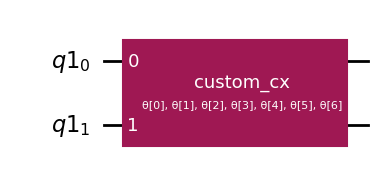

In [16]:
from qiskit.quantum_info import average_gate_fidelity
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import CXGate
from qiskit.circuit import ParameterVector

qr = QuantumRegister(2)
qc = QuantumCircuit(qr)
theta = ParameterVector("θ", 7)
q_env.parametrized_circuit_func(qc, theta, qr, target={"gate": CXGate()})
qc.draw("mpl")

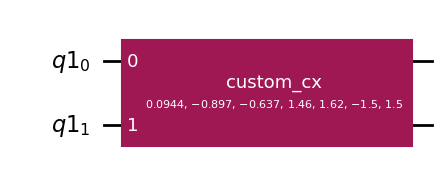

In [17]:
qc.assign_parameters(q_env.optimal_action, inplace=True)
qc.draw("mpl")

In [18]:
from qiskit.quantum_info import Operator

average_gate_fidelity(Operator(qc), q_env.target["gate"])

0.9928420818748792